In [1]:
%matplotlib inline

import json

import numpy as np
import networkx as nx


def json_to_digraph(file_path):
    """
    Load a neuronal reconstruction from a JSON file into a NetworkX graph.

    The JSON file contains neuronal data with additional brain region information for each node.
    The graph will be a simple, directed, rooted tree with no cycles or nodes with more than one parent.

    Parameters:
    file_path (str): The path to the JSON file containing the neuronal reconstruction data.

    Returns:
    nx.DiGraph: A directed graph representing the neuronal tree.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Create directed graphs for axon and dendrite
    axon_graph = nx.DiGraph()
    dendrite_graph = nx.DiGraph()

    # Process dendrite and axon separately
    for structure, graph in [('dendrite', dendrite_graph), ('axon', axon_graph)]:
        for node in sorted(data['neuron'][structure], key=lambda x: x['sampleNumber']):
            # Add the node with attributes
            graph.add_node(node['sampleNumber'], 
                           pos=(node['x'], node['y'], node['z']), 
                           radius=node['radius'], 
                           structure_id=node['structureIdentifier'],
                           allen_id=node['allenId'])

            # Add an edge from parent to this node (if parent exists)
            if node['parentNumber'] != -1:
                graph.add_edge(node['parentNumber'], node['sampleNumber'])

    return axon_graph, dendrite_graph

In [2]:
file_path = "../data/neuron_tracings/mouselight/AA0001.json"

# Load the neuronal tree into a NetworkX graph
axon, dendrite = json_to_digraph(file_path)

# Returning a sample of the graph object (to check if it's loaded correctly)
list(dendrite.nodes(data=True))[:5], list(dendrite.edges())[:5]

# Some basic validation to make sure we did this correctly
assert nx.number_of_selfloops(axon) == 0 and nx.number_of_selfloops(dendrite) == 0
assert nx.is_tree(axon) and nx.is_tree(dendrite)

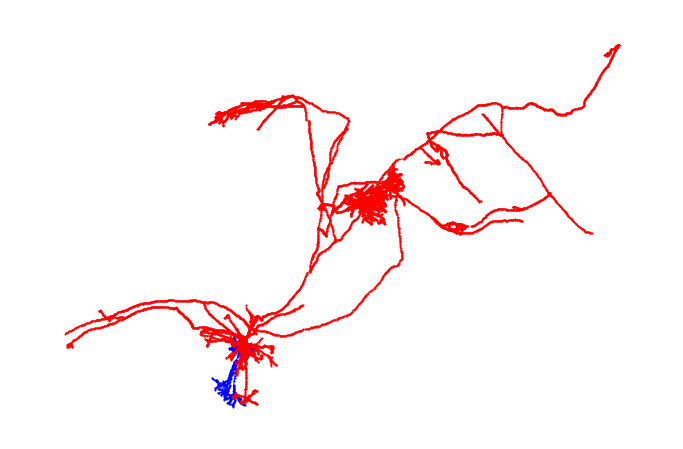

In [3]:
import matplotlib.pyplot as plt

def plot_graph_2d(graph, ax, color="blue"):
    """
    Generate a 2D plot of a neuronal tree graph using matplotlib.

    Parameters:
    graph (nx.DiGraph): A directed graph representing the neuronal tree.
    """
    # Extracting node positions
    pos = {node: data['pos'][:2] for node, data in graph.nodes(data=True)}

    nx.draw(
        graph, 
        pos,
        ax=ax,
        arrows=False,
        # arrowstyle='->', 
        # arrowsize=1, 
        width=1,
        with_labels=False, 
        node_size=1, 
        node_color=color,
        edge_color=color
    )
    
    
fig, ax = plt.subplots(figsize=(12, 8))

plot_graph_2d(dendrite, ax, "blue")
plot_graph_2d(axon, ax, "red")

plt.show()

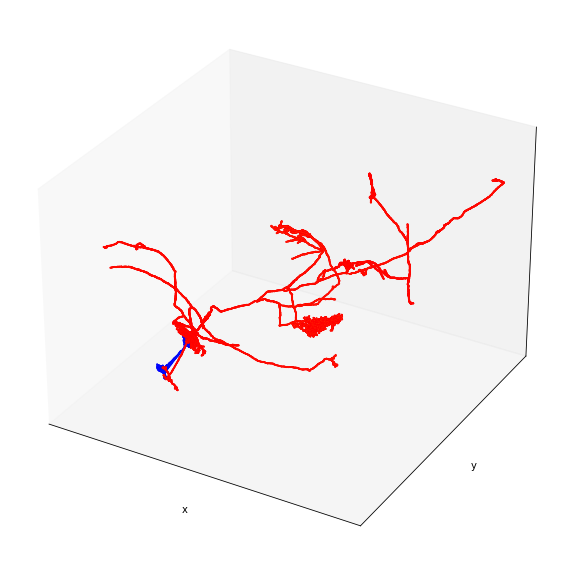

In [4]:
def plot_graph_3d(graph, ax, color='blue'):
    from mpl_toolkits.mplot3d import Axes3D

    pos = nx.get_node_attributes(graph, 'pos')
    
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(graph)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in graph.edges()])

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=1, ec=color)

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color=color)

    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

    _format_axes(ax)
    
    
# Create the 3D figure
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="3d")

plot_graph_3d(dendrite, ax, "blue")
plot_graph_3d(axon, ax, "red")

fig.tight_layout()
plt.show()